<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U -q "tf-models-official"
!pip install tf-slim
!pip install tensorflow-hub
!pip install tensorflow-object-detection-api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.2 MB/s eta 0:00:00


In [5]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen


In [6]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4)  # Set Pretty Print Indentation
print(tf.__version__)  # Check the version of TensorFlow used

%matplotlib inline


2.18.0


In [8]:
from google.colab import files
uploaded = files.upload()


Saving API_SatelliteData.zip to API_SatelliteData.zip


In [9]:
# To check the uploaded files
uploaded.keys()


dict_keys(['API_SatelliteData.zip'])

In [11]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('API_SatelliteData.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')


In [12]:
import os

# List the files in the extracted folder
os.listdir('/content/dataset/')


['SatelliteData']

In [13]:
import os

# List the contents of the extracted folder
os.listdir('/content/dataset/SatelliteData')


['train', 'validate', 'test']

In [14]:
# List the contents of each folder to check the images and annotations
train_images = os.listdir('/content/dataset/SatelliteData/train')
validate_images = os.listdir('/content/dataset/SatelliteData/validate')
test_images = os.listdir('/content/dataset/SatelliteData/test')

print(f"Train images: {len(train_images)}")
print(f"Validate images: {len(validate_images)}")
print(f"Test images: {len(test_images)}")


Train images: 2
Validate images: 2
Test images: 2


In [16]:
# List all contents in the 'SatelliteData' folder
os.listdir('/content/dataset/SatelliteData')


['train', 'validate', 'test']

In [17]:
# List all files in the 'SatelliteData' folder (including subdirectories)
for root, dirs, files in os.walk('/content/dataset/SatelliteData'):
    print(f"Directory: {root}")
    print(f"Files: {files}")


Directory: /content/dataset/SatelliteData
Files: []
Directory: /content/dataset/SatelliteData/train
Files: []
Directory: /content/dataset/SatelliteData/train/images
Files: ['leganes_derecha_abajo_2_40.3033989_-3.7513294.jpg', 'leganes_derecha_abajo _40.3259374_-3.7309682.jpg', 'Madrid_norte_40.5449732_-3.6554552.jpg', 'leganes_parkings _40.3297243_-3.7387991.jpg', 'leganes_derecha_abajo_2_40.2927189_-3.7443094.jpg', 'Madrid_norte_40.5529832_-3.6519452.jpg', 'Madrid_norte_2_40.5539639_-3.6113772.jpg', 'leganes_parkings _40.3377343_-3.7282691.jpg', 'leganes_derecha_abajo_2_40.3033989_-3.7478194.jpg', 'Madrid_norte_40.5529832_-3.6484352.jpg', 'leganes_derecha_abajo _40.3179274_-3.7309682.jpg', 'leganes_derecha_abajo _40.3205974_-3.7274582.jpg', 'leganes_parkings _40.3377343_-3.7352891.jpg', 'Madrid_norte_2_40.5432839_-3.6254172.jpg', 'leganes_izq1_40.3381344_-3.7834516.jpg', 'fuentelareyna_40.479813_-3.7345979.jpg', 'Madrid_norte_2_40.5406139_-3.6113772.jpg', 'leganes_izq1_40.3434744_-3.7

In [21]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np

# Paths to your directories
train_images_dir = '/content/dataset/SatelliteData/train/images'
train_annotations_dir = '/content/dataset/SatelliteData/train/annotations'

val_images_dir = '/content/dataset/SatelliteData/validate/images'
val_annotations_dir = '/content/dataset/SatelliteData/validate/annotations'

test_images_dir = '/content/dataset/SatelliteData/test/images'
test_annotations_dir = '/content/dataset/SatelliteData/test/annotations'

# Function to load images and labels
def load_data(images_dir, annotations_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    annotation_files = [f.replace('.jpg', '.xml') for f in image_files]

    images = []
    labels = []

    for img_file, ann_file in zip(image_files, annotation_files):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = Image.open(img_path)
        images.append(np.array(image))

        # Load annotation (XML) and parse the object labels
        ann_path = os.path.join(annotations_dir, ann_file)
        tree = ET.parse(ann_path)
        root = tree.getroot()

        objects = []
        for obj in root.findall('object'):
            label = obj.find('name').text  # Extract the label name
            objects.append(label)

        labels.append(objects)

    return images, labels

# Load training, validation, and test data
train_images, train_labels = load_data(train_images_dir, train_annotations_dir)
val_images, val_labels = load_data(val_images_dir, val_annotations_dir)
test_images, test_labels = load_data(test_images_dir, test_annotations_dir)

print(f'Training set: {len(train_images)} images')
print(f'Validation set: {len(val_images)} images')
print(f'Test set: {len(test_images)} images')


Training set: 180 images
Validation set: 20 images
Test set: 40 images


In [27]:
validation_dir = '/content/drive/MyDrive/satelitedata/validate'  # Adjust to the correct path


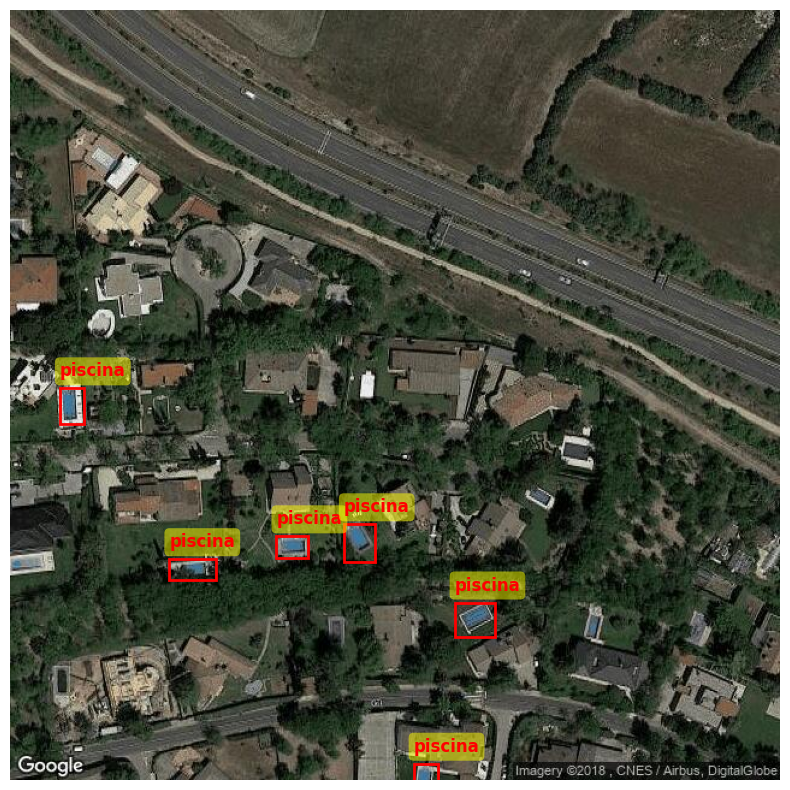

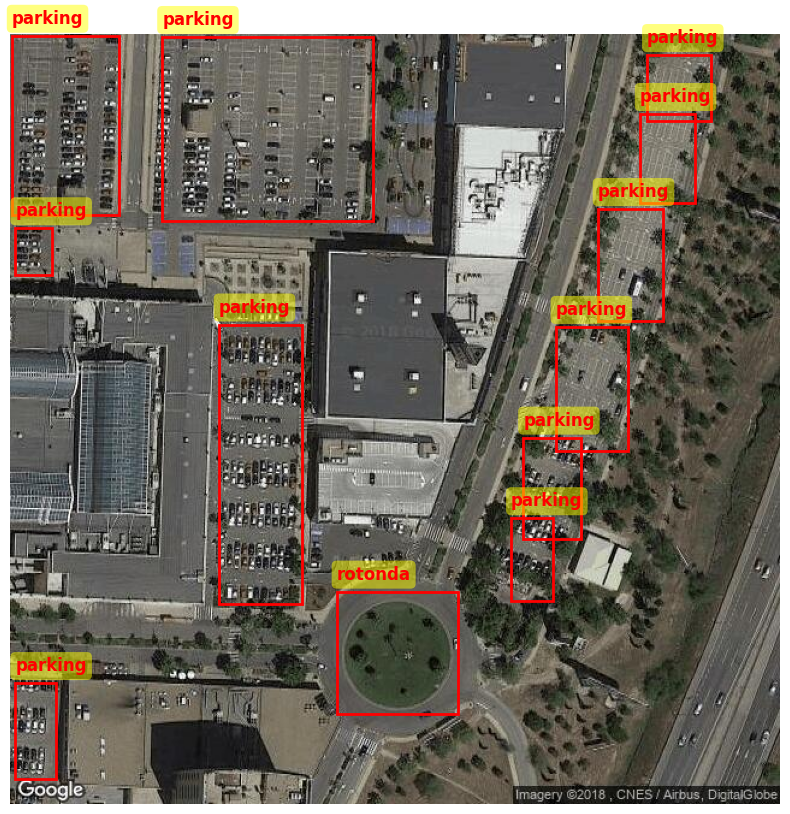

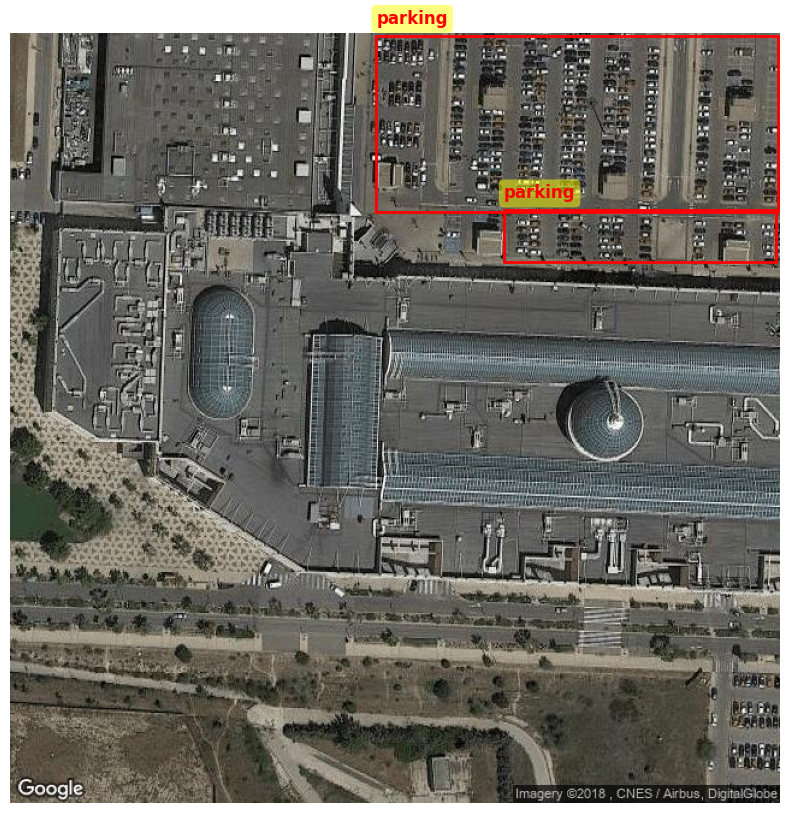

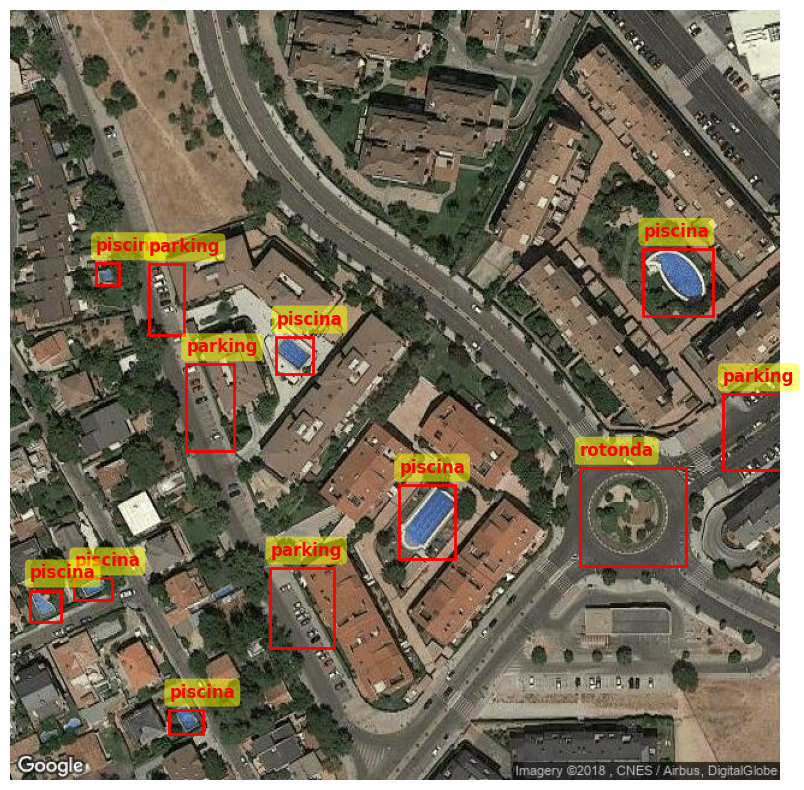

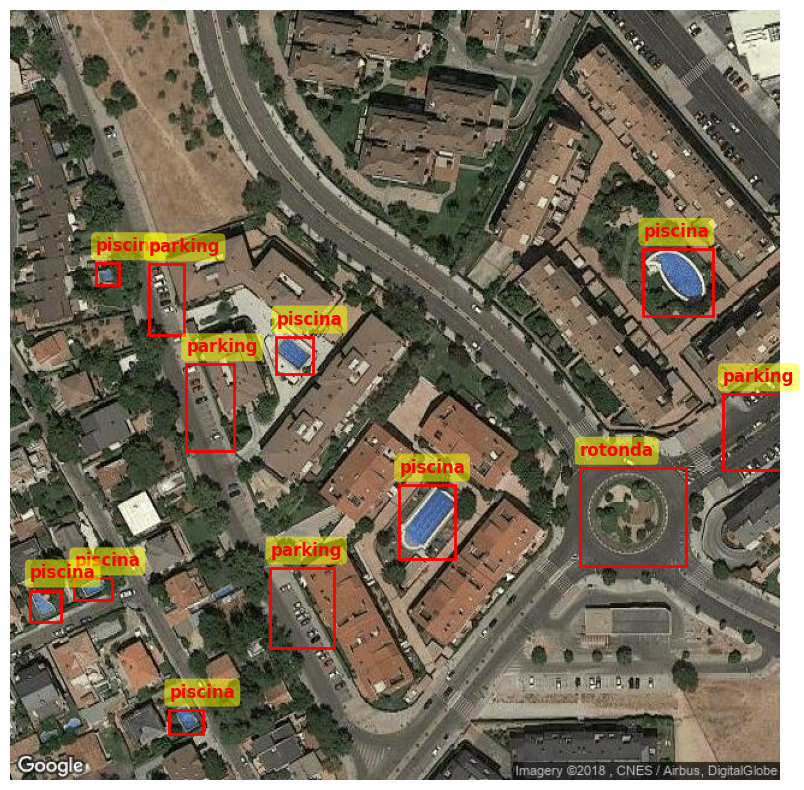

In [30]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Function to load images and annotations from the validation set
def load_validation_data(images_dir, annotations_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]  # List .jpg files in the images directory
    images = []
    labels = []

    for image_file in image_files:
        # Load the image
        image_path = os.path.join(images_dir, image_file)
        image = Image.open(image_path)
        images.append(image)

        # Get the corresponding annotation file
        annotation_file = image_file.replace('.jpg', '.xml')  # Assuming annotations are in XML format
        annotation_path = os.path.join(annotations_dir, annotation_file)

        if os.path.exists(annotation_path):
            # Parse the XML annotation file
            tree = ET.parse(annotation_path)
            root = tree.getroot()

            # Extract bounding boxes and labels
            image_labels = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                bndbox = obj.find('bndbox')
                x_min = int(bndbox.find('xmin').text)
                y_min = int(bndbox.find('ymin').text)
                x_max = int(bndbox.find('xmax').text)
                y_max = int(bndbox.find('ymax').text)
                image_labels.append([x_min, y_min, x_max, y_max, label])  # Format: [xmin, ymin, xmax, ymax, label]
            labels.append(image_labels)
        else:
            labels.append([])  # No annotations for this image

    return images, labels

# Function to display random validation samples with bounding boxes and labels
def show_sample_images(images, labels, num_samples=5):
    for i in range(num_samples):
        # Select a random index
        idx = random.randint(0, len(images) - 1)
        image = images[idx]
        label = labels[idx]

        # Display the image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)

        # Draw bounding boxes and show labels on the image
        for box in label:
            x_min, y_min, x_max, y_max, label_text = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='red', facecolor='none'))
            # Display the label near the bounding box
            plt.text(x_min, y_min - 10, label_text, color='red', fontsize=12, fontweight='bold',
                     bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

        plt.axis('off')
        plt.show()

# Load validation data
validation_images, validation_labels = load_validation_data(val_images_dir, val_annotations_dir)

# Show random validation samples with bounding boxes and labels
show_sample_images(validation_images, validation_labels, num_samples=5)
